In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import numpy as np
import numpy.linalg as la
import scipy
import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Project 
1. Use a subset of the S&P 500 to create a sparse graph representation of the correlations.
   1. Only use correlations higher than 0.85 absolute value to add sparsity. Throw away everything else.
2. Use the egonet of each of these nodes to construct an embedding based upon the following:
   1. W - The total weights of each edge
   2. E - Number of edges
   3. N - Number of neighbors
   4. Maybe more depending on time. (Principal eigenvalue, median)
3. Query a stock q_i to see which embedding it is closest with.
4. Construct a portfolio made up of its cluster and check its market beta.

## Part 1
### Create a train/test split using the S&P 500 data

In [2]:
sp500_df = pd.read_csv("data/sp500_close.csv")
sp500_df.set_index("Date", inplace=True)
sp500_df

A    AAPL    ABBV    ABNB     ABT   ACGL     ACN  \
Date                                                                         
2022-10-31 04:00:00  138.35  153.34  146.40  106.91   98.94  57.50  283.90   
2022-11-01 04:00:00  140.89  150.65  146.91  109.05   99.31  55.44  281.47   
2022-11-02 04:00:00  135.27  145.03  144.52   94.41   98.04  56.22  272.45   
2022-11-03 04:00:00  134.46  138.88  144.42   92.02   96.45  56.53  256.88   
2022-11-04 04:00:00  136.08  138.38  145.28   96.09   98.07  56.86  261.16   
...                     ...     ...     ...     ...     ...    ...     ...   
2023-12-22 05:00:00  139.57  193.60  154.94  140.80  109.03  73.84  354.45   
2023-12-26 05:00:00  139.81  193.05  154.62  138.72  109.23  73.51  353.43   
2023-12-27 05:00:00  139.82  193.15  154.88  136.55  109.79  73.54  353.82   
2023-12-28 05:00:00  139.77  193.58  154.75  137.00  110.40  74.06  351.59   
2023-12-29 05:00:00  139.03  192.53  154.97  136.14  110.07  74.27  350.91   

                       ADBE     ADI    ADM  ...     WTW     WY   WYNN    XEL  \
Date                                        ...                                
2022-10-31 04:00:00  318.50  142.62  96.98  ...  218.21  30.93  63.90  65.11   
2022-11-01 04:00:00  316.02  144.70  97.53  ...  221.20  30.39  67.86  65.90   
2022-11-02 04:00:00  301.22  141.24  95.80  ...  220.13  29.66  67.13  65.31   
2022-11-03 04:00:00  285.93  138.02  96.28  ...  217.96  29.39  66.48  65.15   
2022-11-04 04:00:00  285.75  144.29  95.19  ...  221.21  30.28  70.81  65.55   
...                     ...     ...    ...  ...     ...    ...    ...    ...   
2023-12-22 05:00:00  598.75  197.10  71.46  ...  240.09  34.36  90.42  62.06   
2023-12-26 05:00:00  598.26  198.87  72.39  ...  239.09  34.63  91.00  62.25   
2023-12-27 05:00:00  596.08  199.35  72.17  ...  239.30  34.76  90.63  61.54   
2023-12-28 05:00:00  595.52  200.24  72.27  ...  239.32  35.10  91.76  61.89   
2023-12-29 05:00:00  596.60  198.56  72.22  ...  241.20  34.77  91.11  61.91   

                        XOM     XYL     YUM     ZBH    ZBRA     ZTS  
Date                                                                 
2022-10-31 04:00:00  110.81  102.43  118.25  113.35  283.22  150.78  
2022-11-01 04:00:00  111.91  105.54  118.15  111.84  238.30  152.72  
2022-11-02 04:00:00  109.61  104.27  117.37  107.69  236.03  147.36  
2022-11-03 04:00:00  111.10  107.17  119.50  105.42  227.32  131.14  
2022-11-04 04:00:00  112.31  107.21  121.78  104.85  230.56  133.67  
...                     ...     ...     ...     ...     ...     ...  
2023-12-22 05:00:00  101.91  112.64  130.00  120.56  269.41  194.98  
2023-12-26 05:00:00  102.14  113.62  130.26  121.42  275.50  195.50  
2023-12-27 05:00:00  101.66  114.38  130.84  121.13  275.79  196.90  
2023-12-28 05:00:00  100.19  114.32  130.52  121.63  275.35  197.16  
2023-12-29 05:00:00   99.98  114.36  130.66  121.70  273.33  197.37  

[293 rows x 489 columns]

In [3]:
# Create train/test split based on ticker
train_size = 0.8
train_date_range = ["2022-10-31", "2023-09-30"]
train_index = random.sample(list(sp500_df.columns), int(train_size * len(sp500_df.columns)), )
train_df = sp500_df[train_index]
test_df = sp500_df.drop(train_df.columns, axis=1)

train_df = train_df[train_date_range[0]:train_date_range[1]]
test_df = test_df[train_date_range[0]:train_date_range[1]]

len(train_df.columns), len(test_df.columns)

(391, 98)

In [4]:
# View the train_df
train_df

NKE      BG    AEE   PYPL     DRI      DE      CTAS  \
Date                                                                         
2022-10-31 04:00:00  92.68   98.70  81.52  83.58  143.14  395.82  106.8875   
2022-11-01 04:00:00  93.77   99.77  82.12  83.11  143.04  388.71  107.0675   
2022-11-02 04:00:00  90.30   99.18  81.17  79.45  139.71  385.95  103.9525   
2022-11-03 04:00:00  90.40   98.73  81.14  76.55  139.47  393.63  102.7350   
2022-11-04 04:00:00  95.79   99.53  81.03  75.18  141.34  395.09  102.6600   
...                    ...     ...    ...    ...     ...     ...       ...   
2023-09-25 04:00:00  90.60  110.69  79.55  58.86  141.27  384.39  126.3800   
2023-09-26 04:00:00  90.17  108.96  76.85  58.93  141.36  379.63  119.7175   
2023-09-27 04:00:00  89.42  109.57  76.11  57.34  141.43  384.36  120.2700   
2023-09-28 04:00:00  89.63  110.61  74.44  58.18  143.10  384.73  120.9725   
2023-09-29 04:00:00  95.62  108.25  74.83  58.46  143.22  377.38  120.2525   

                         C     PTC    BAX  ...      BX     IBM     APH    MOS  \
Date                                       ...                                  
2022-10-31 04:00:00  45.86  117.83  54.35  ...   91.14  138.29  37.915  53.75   
2022-11-01 04:00:00  46.22  118.02  53.74  ...   92.94  138.20  38.385  54.45   
2022-11-02 04:00:00  45.55  115.73  51.93  ...   92.35  136.83  37.015  51.89   
2022-11-03 04:00:00  44.58  123.17  50.44  ...   88.03  134.47  37.125  48.84   
2022-11-04 04:00:00  45.13  124.24  50.58  ...   90.04  136.96  38.135  49.29   
...                    ...     ...    ...  ...     ...     ...     ...    ...   
2023-09-25 04:00:00  41.02  140.87  37.50  ...  110.30  146.48  41.630  36.11   
2023-09-26 04:00:00  40.22  138.20  37.32  ...  105.94  143.24  40.730  35.40   
2023-09-27 04:00:00  40.46  138.47  37.33  ...  106.55  143.17  41.180  35.20   
2023-09-28 04:00:00  41.20  141.20  37.54  ...  108.23  141.58  42.040  35.84   
2023-09-29 04:00:00  41.13  141.68  37.74  ...  107.14  140.30  41.995  35.60   

                      QRVO    REG     SYK     MSI      CF     ON  
Date                                                              
2022-10-31 04:00:00  86.08  60.51  229.24  249.71  106.26  61.43  
2022-11-01 04:00:00  86.51  61.92  220.09  242.89  107.80  61.74  
2022-11-02 04:00:00  84.48  60.51  211.97  239.90  103.17  60.11  
2022-11-03 04:00:00  82.67  60.29  205.51  238.18  105.24  59.19  
2022-11-04 04:00:00  86.85  63.57  210.98  254.87  105.38  63.19  
...                    ...    ...     ...     ...     ...    ...  
2023-09-25 04:00:00  96.50  60.68  287.38  276.66   85.94  94.46  
2023-09-26 04:00:00  94.81  59.26  273.55  273.50   85.13  90.15  
2023-09-27 04:00:00  94.56  59.13  266.54  272.98   83.45  92.05  
2023-09-28 04:00:00  95.47  60.11  273.41  274.19   85.97  94.05  
2023-09-29 04:00:00  95.47  59.44  273.27  272.24   85.74  92.95  

[230 rows x 391 columns]

In [40]:
# Calculate correlation matrix
corr_matrix = train_df.corr()
px.imshow(corr_matrix)

In [6]:
def graph_from_adj_matrix(adj_matrix, node_list, threshold=0.85):
    G = nx.Graph()
    G.add_nodes_from(node_list)
    for i in range(len(node_list)):
        for j in range(i+1, len(node_list)):
            if abs(adj_matrix[i, j]) > threshold:
                G.add_edge(node_list[i], node_list[j], weight=adj_matrix[i, j])

    return G

G = graph_from_adj_matrix(corr_matrix.values, corr_matrix.columns, threshold=0.85)
len(G.nodes), len(G.edges)

(391, 3214)

In [7]:
def draw_graph(G):
    # G = nx.random_geometric_graph(200, 0.125)
    pos = nx.spring_layout(G)
    # pos = nx.bipartite_layout(G, G.nodes)
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_text = []
    for node in G.nodes():
        node_text.append(node)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        hovertext=node_text,
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title=dict(
                text='Node Connections',
                side='right'
                ),
                xanchor='left',
            ),
            line_width=2))


    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('# of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=dict(
                        text="<br>Network graph made with Python",
                        font=dict(
                            size=16
                        )
                    ),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Python code: <a href='https://plotly.com/python/network-graphs/'> https://plotly.com/python/network-graphs/</a>",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show(renderer="browser")

In [41]:
# Draw correlation graph representation. Opens in browser.
draw_graph(G)

In [9]:
adj_matrix = nx.adjacency_matrix(G).todense()
adj_matrix, len(adj_matrix)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 391)

### Create sparse graph representation using Colibri-S

In [10]:
def loss(m1, m2):
    return la.norm(m1-m2, ord='fro')

def SVD(adj_matrix, c):
    c_rows = int(np.ceil(c*adj_matrix.shape[0]))
    L, M, R = np.linalg.svd(adj_matrix)
    A = np.dot(L[:,:c_rows] * M[:c_rows], R[:c_rows, :])

    return A

def ColibriS(adj_matrix, c, epsilon=0.5):
    A = adj_matrix
    c_rows = int(np.ceil(c*A.shape[0]))

    A_A = A**2
    p_x = A_A.sum(axis=0)/A_A.sum()
    I = np.random.choice(A.shape[1], size=(c_rows,), p=p_x)
    L = A[:, I[0]].reshape((A.shape[0], 1))
    M = (1/(L.transpose() @ L)).reshape((1,1))

    for k in range(1, c_rows):
        res = A[:, I[k]] - L @ M @ L.transpose() @ A[:, I[k]]
        if la.norm(res) < epsilon*la.norm(A[:, I[k]]):
            continue
        else:
            delta = la.norm(res) ** 2
            y = (M @ L.transpose() @ A[:, I[k]]).reshape((M.shape[0],1))
            M_lu = M + y @ y.transpose() / (delta ** 2)
            M_u = np.concatenate((M_lu, -y/delta), axis=1)
            M_d = np.concatenate((-y.transpose()/delta, np.array(1/delta).reshape((1,1))), axis=1)
            M = np.concatenate((M_u, M_d), axis=0)
            L = np.concatenate((L, A[:, I[k]].reshape(A.shape[0], 1)), axis=1)

    R = L.transpose() @ A
    A_reconstruct = L @ M @ R
    adj_matrix_reconstruct = A_reconstruct

    return L, M, R, adj_matrix_reconstruct

In [11]:
L, M, R, adj_matrix_reconstruct = ColibriS(adj_matrix, 0.3)
L.shape, M.shape, R.shape, adj_matrix_reconstruct.shape

((391, 115), (115, 115), (115, 391), (391, 391))

In [42]:
G_reconstruct = graph_from_adj_matrix(adj_matrix_reconstruct, corr_matrix.columns, threshold=0.85)
draw_graph(G_reconstruct)
loss(adj_matrix_reconstruct, adj_matrix)

np.float64(90.28599931891976)

In [13]:
svd_reconstruct = SVD(adj_matrix, 0.3)

In [43]:
G_svd_reconstruct = graph_from_adj_matrix(svd_reconstruct, corr_matrix.columns, threshold=0.85)
draw_graph(G_svd_reconstruct)
loss(svd_reconstruct, adj_matrix)

np.float64(12.631648924324843)

In [15]:
# Throw away all nodes with fewer than 3 connections
def filter_graph(G, threshold=3):
    G_filtered = G.copy()
    for node in G.nodes():
        if len(G.edges(node)) < threshold:
            G_filtered.remove_node(node)

    return G_filtered

G_filtered = filter_graph(G_reconstruct)

In [44]:
draw_graph(G_filtered)

Graph G represents the original Graph

Graph G_reconstruct represents the reconstructed Colibiri-S LMR graph

Graph G_svd_reconstruct represents the reconstructed SVD graph

## Part 2
### Create egonet embedding

In [17]:
def egonet_f_num_neighbors(node, egonet: nx.Graph):
    # Return the number of neighbors in the egonet
    return egonet.degree(node)


def egonet_f_num_edges(node, egonet: nx.Graph):
    # Return the number of edges in the egonet
    return egonet.size() - egonet.degree(node)


def egonet_f_total_weight(node, egonet: nx.Graph):
    # Return the total weight of the edges in the egonet
    return sum([d['weight'] for u, v, d in egonet.edges(data=True)])


def egonet_f_principal_eigenvalue(node, egonet: nx.Graph):
    # Return the principal eigenvalue of the adjacency matrix of the egonet
    adj_matrix = nx.adjacency_matrix(egonet).todense()
    return max(np.linalg.eigvals(adj_matrix).real)


def egonet_embedding(node: str, graph: nx.Graph, functions=[]):
    # Get the neighbors of the node and all edges connecting them
    if node not in graph.nodes:
        raise ValueError("Node not found in graph")

    neighbors = set(graph.neighbors(node))
    egonet_nodes = neighbors | {node}
    # Subgraph induced by the egonet nodes
    egonet_subgraph = graph.subgraph(egonet_nodes)

    embedding = []
    for f in functions:
        embedding.append(f(node, egonet_subgraph))

    return embedding


In [18]:
# For each node, calculate its embedding using the full Graph
embeddings = {}

embedding_functions = {
    "num_neighbors": egonet_f_num_neighbors,
    "num_edges": egonet_f_num_edges,
    "total_weight": egonet_f_total_weight,
}

for node in G_filtered.nodes():
    embeddings[node] = egonet_embedding(node, G, functions=embedding_functions.values())

embeddings

{'CTAS': [50, 892, np.float64(799.4768556251375)],
 'PTC': [47, 784, np.float64(717.5317012488129)],
 'ORLY': [28, 269, np.float64(241.83316660846643)],
 'AEP': [30, 168, np.float64(133.4733386714951)],
 'STZ': [4, 0, np.float64(3.5008981527080425)],
 'CCI': [45, 422, np.float64(134.16166174499827)],
 'BMY': [52, 796, np.float64(365.8042111964835)],
 'GE': [67, 1241, np.float64(762.3740984064381)],
 'META': [78, 1708, np.float64(1108.9471157050748)],
 'SBAC': [49, 526, np.float64(147.0891513870387)],
 'ECL': [66, 1465, np.float64(1239.1610134844254)],
 'INCY': [49, 599, np.float64(244.4224394548236)],
 'NFLX': [54, 1068, np.float64(1019.1875319591228)],
 'FICO': [69, 1461, np.float64(1101.9282274621007)],
 'VRSK': [81, 1740, np.float64(1215.5735000006102)],
 'SMCI': [65, 1375, np.float64(1089.1300022448602)],
 'ZTS': [10, 44, np.float64(49.88345475414511)],
 'NVDA': [82, 1874, np.float64(1265.9012827323854)],
 'NOW': [71, 1655, np.float64(1331.1403255583061)],
 'CAH': [23, 167, np.floa

In [19]:
# Visualize embeddings
embeddings_df = pd.DataFrame(embeddings).transpose()
embeddings_df.columns = list(embedding_functions.keys())

fig = px.scatter_3d(embeddings_df, x='num_neighbors', y='num_edges', z='total_weight', text=embeddings_df.index)
fig.show(renderer="browser")

## Part 3
### Calculate Clusters on the embeddings

In [20]:
# Create clusters based on embeddings using KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=RANDOM_SEED).fit(embeddings_df)
embeddings_df['cluster'] = kmeans.labels_

fig = px.scatter_3d(embeddings_df, x='num_neighbors', y='num_edges', z='total_weight', text=embeddings_df.index, color='cluster')
fig.show(renderer="browser")

In [21]:
# Calculate a representation of the stock movement for each cluster using the average of the stock movements of the nodes in the cluster
cluster_representations = {}
for cluster in embeddings_df['cluster'].unique():
    cluster_nodes = embeddings_df[embeddings_df['cluster'] == cluster].index
    cluster_representations[cluster] = train_df[cluster_nodes].mean(axis=1)

cluster_representations_df = pd.DataFrame(cluster_representations)

fig = px.line(cluster_representations_df)
fig.show(renderer="browser")

### Try querying using a stock in the test set, and assign it to a cluster

In [22]:
# Create a function to query the best cluster based on correlation to the test data
def query(ticker, cluster_representations_df):
    best_cluster = None
    best_correlation = -1
    for cluster in cluster_representations_df.columns:
        correlation = test_df[ticker].corr(cluster_representations_df[cluster])
        if correlation > best_correlation:
            best_cluster = cluster
            best_correlation = correlation

    return best_cluster

# Query the best cluster for each ticker in the test data
best_clusters = {}
for ticker in test_df.columns:
    best_clusters[ticker] = query(ticker, cluster_representations_df)

best_clusters_df = pd.DataFrame(best_clusters, index=['cluster']).transpose()
best_clusters_df

cluster
ABT         3
ACN         0
ADBE        0
ADSK        3
ALGN        2
...       ...
V           2
VLO         3
VMC         0
WBA         3
WFC         3

[98 rows x 1 columns]

## Part 4
### Create a representative portfolio using a basket of stocks in the same cluster from the training set

In [45]:
# Get the cluster for that stock
ticker = "ABT"
cluster_id = best_clusters_df.loc[ticker, 'cluster']
print(cluster_id)

portfolio = embeddings_df[embeddings_df['cluster'] == cluster_id].index
portfolio

3


Index(['BMY', 'SBAC', 'INCY', 'TAP', 'BR', 'EQIX', 'MRNA', 'AMCR', 'T', 'AES',
       'STE'],
      dtype='object')

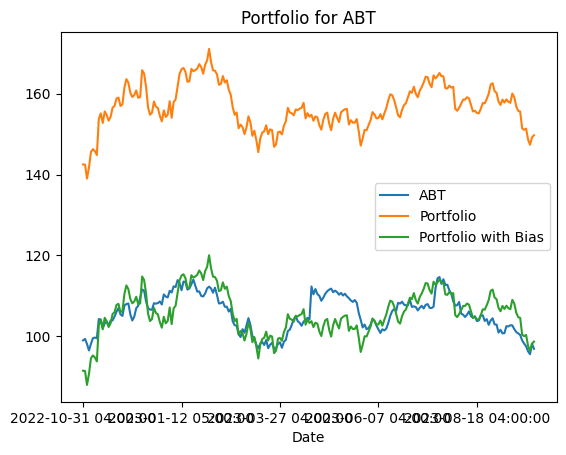

In [46]:
# Plot the portfolio stock movements with the ticker
portfolio_df = sp500_df[portfolio][train_date_range[0]:train_date_range[1]]
ticker_series = sp500_df[ticker][train_date_range[0]:train_date_range[1]]
ticker_series.plot()
portfolio_series = portfolio_df.mean(axis=1)
portfolio_series.plot()
portfolio_series_bias = portfolio_series + ticker_series.mean() - portfolio_series.mean()
portfolio_series_bias.plot()
plt.legend([ticker, "Portfolio", "Portfolio with Bias"])
plt.title(f"Portfolio for {ticker}")
plt.show()

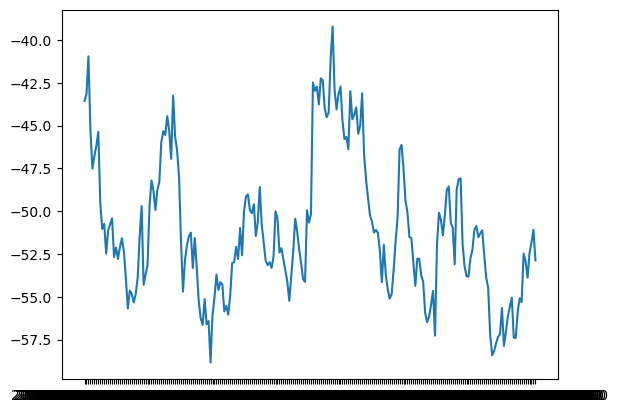

In [27]:
# Look at some pairs trading data between the portfolio and the ticker
r = ticker_series - portfolio_series

plt.plot(r)

## Test

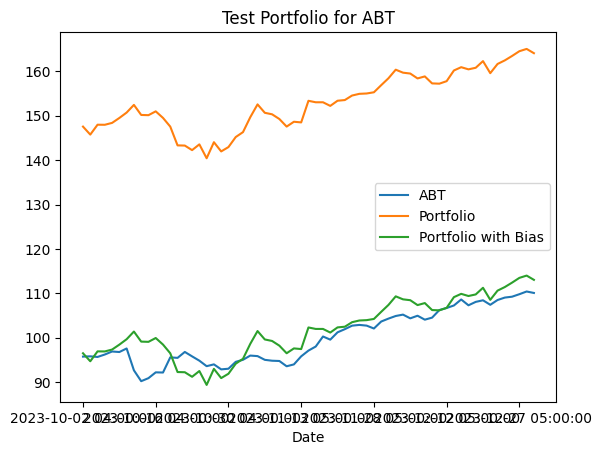

In [33]:
bias = ticker_series.mean() - portfolio_series.mean()

test_ticker_series = sp500_df[ticker][train_date_range[1]:]
test_portfolio_series = sp500_df[portfolio][train_date_range[1]:].mean(axis=1)
test_portfolio_series_bias = test_portfolio_series + bias

test_ticker_series.plot()
test_portfolio_series.plot()
test_portfolio_series_bias.plot()
plt.legend([ticker, "Portfolio", "Portfolio with Bias"])
plt.title(f"Test Portfolio for {ticker}")
plt.show()

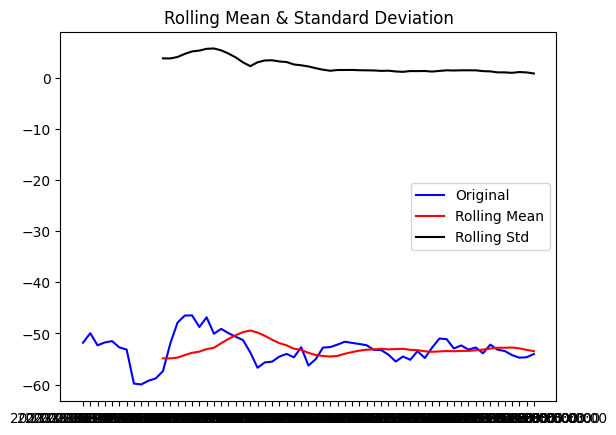

Results of Dickey-Fuller Test:
Test Statistic                 -3.052887
p-value                         0.030242
#Lags Used                     10.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64
Is the time series stationary? True


In [38]:
# Look at stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    print(f"Is the time series stationary? {dftest[1] < 0.05}")

test_stationarity(test_ticker_series - test_portfolio_series)

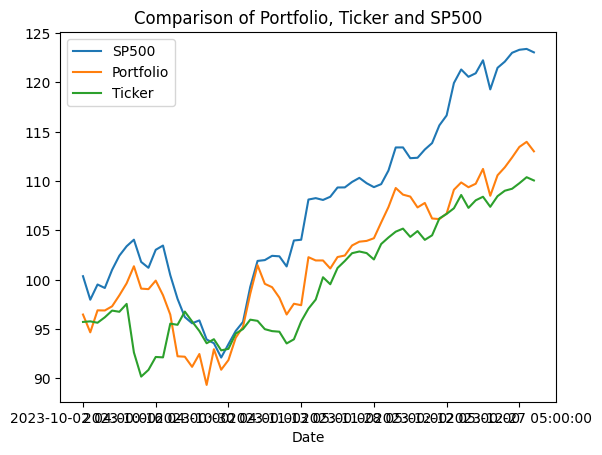

In [48]:
# Compare it with entire SP500
sp500_series = sp500_df.mean(axis=1)
sp500_bias = test_ticker_series.mean() - sp500_series[train_date_range[0]:train_date_range[1]].mean()
test_sp500_series = sp500_series[train_date_range[1]:]
test_sp500_series_bias = test_sp500_series + sp500_bias
test_sp500_series_bias.plot()
test_portfolio_series_bias.plot()
test_ticker_series.plot()
plt.legend(["SP500", "Portfolio", "Ticker"])
plt.title("Comparison of Portfolio, Ticker and SP500")
plt.show()


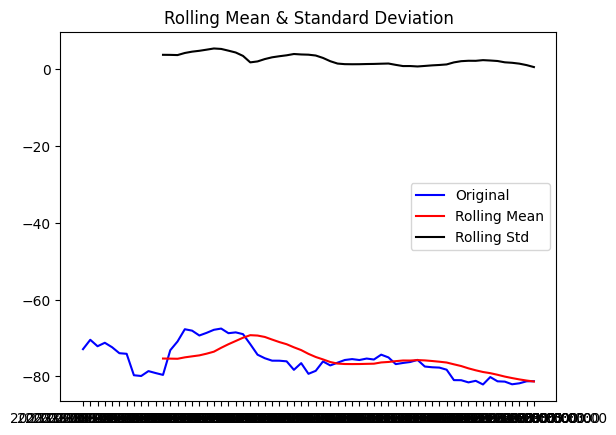

Results of Dickey-Fuller Test:
Test Statistic                 -1.354721
p-value                         0.603781
#Lags Used                      0.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64
Is the time series stationary? False


In [49]:
# Calculate stationarity of the SP500 comapred with ticker series
test_stationarity(test_ticker_series - test_sp500_series)